In [1]:
#https://keras.io/examples/ -> Timeseries classification
#https://keras.io/examples/timeseries/eeg_signal_classification/
#https://towardsdatascience.com/time-series-analysis-on-multivariate-data-in-tensorflow-2f0591088502

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os

#date = "230324"
date = "230517"
DATA_DIR = os.path.join("..", date)

import pandas as pd
import numpy as np
import math
from statistics import mean
import matplotlib.pyplot as plt
from itertools import groupby

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn import preprocessing, model_selection

In [3]:
run_num = 1
post_op = True
#filename = "Run_1_attention.xlsx"
if date == "230324":
    filename = "Run_" + str(run_num) +"_attention.xlsx"
elif date == "230517":
    if run_num == 1:
        filename = "20230517T074332Z.xlsx"
    elif run_num == 2:
        filename = "20230517T084019Z.xlsx"
    else:
        filename = "20230517T100316Z.xlsx"

output_filename = "av_metrics_" + date + "_run" + str(run_num) + ".csv"

full_filename = os.path.join(DATA_DIR, filename)


In [4]:
df = pd.read_excel(full_filename)
print(df.head(1))

   Recording timestamp  Computer timestamp Sensor Recording start time  \
0                    0                   0    NaN         09:43:32.124   

   Recording duration Recording Fixation filter name           Event  \
0             2815701         Tobii I-VT (Attention)  RecordingStart   

   Pupil diameter left  Pupil diameter right  Pupil diameter filtered  \
0                  NaN                   NaN                      NaN   

  Eye movement type  Gaze event duration  Eye movement type index  
0          Fixation                   97                        1  


In [5]:
if date == "230324":
    if run_num == 1:
        filename = "Wl1_Friedrik_230324_093826.csv"
    else:
        filename = "Wl2_Fredrik_230324_112649.csv"
elif date == "230517":
    if run_num == 1:
        filename = "Exp1_Fredrick_230517_084542.csv"
    elif run_num == 2:
        filename = "Exp2_Fredrick2_230517_094640.csv"
    else:
        filename = "Exp3_Fredrick_230517_111130.csv"

full_filename = os.path.join(DATA_DIR, filename)

score_df = pd.read_csv(full_filename, sep=' ',index_col=False)
#print(score_df.head(1))

score_df['score'] = score_df['score'].replace([0], 10)

all_scores = list(score_df['score'])
if post_op:
    all_scores_post_op = list(score_df['post_op_score'])

In [6]:
sec_in_ms=0.000001
timeIntervalDuration = 180 #sec

def getTimeInterval(ms_num):

    return math.ceil(ms_num*sec_in_ms/timeIntervalDuration)

df = df.drop([0])
#fill the null rows with the mean of respective columns
df = df.fillna(df.mean())
df['timeInterval'] = df.apply(lambda row: getTimeInterval(row['Computer timestamp']), axis=1)

In [7]:
print(df.head(5))

   Recording timestamp  Computer timestamp       Sensor Recording start time  \
1                 7027                7027  Eye Tracker         09:43:32.124   
2                27118               27118  Eye Tracker         09:43:32.124   
3                47100               47100  Eye Tracker         09:43:32.124   
4                67190               67190  Eye Tracker         09:43:32.124   
5                87172               87172  Eye Tracker         09:43:32.124   

   Recording duration Recording Fixation filter name Event  \
1             2815701         Tobii I-VT (Attention)   NaN   
2             2815701         Tobii I-VT (Attention)   NaN   
3             2815701         Tobii I-VT (Attention)   NaN   
4             2815701         Tobii I-VT (Attention)   NaN   
5             2815701         Tobii I-VT (Attention)   NaN   

   Pupil diameter left  Pupil diameter right  Pupil diameter filtered  \
1                3.091                 3.131                    3.111   


In [8]:
last_timestamp = list(df['Computer timestamp'])[-1]
print(last_timestamp)
last_timeinterval = getTimeInterval(last_timestamp)
print(last_timeinterval)

diameters = []
intervals = []
num_of_values =[]

for ti in range (1, last_timeinterval + 1):
    ti_df = df[df['timeInterval']==ti]
    ti_diams = ti_df['Pupil diameter filtered'].dropna().tolist()
    diameters.append(ti_diams)
    num_of_values.append(len(ti_diams))
    intervals.append(ti)

print(intervals)
#print(diameters)
print(num_of_values)
min_num = min(num_of_values)
print(min_num)

new_num_of_values = []
for i in range (0, last_timeinterval):
    diameters[i] = diameters[i][-abs(min_num)::1]
    new_num_of_values.append(len(diameters[i]))
print(new_num_of_values)
window_size = min_num

2815701240
16
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[9024, 9020, 9019, 9020, 9020, 9019, 9026, 9020, 9020, 9012, 9020, 9020, 9019, 9020, 9020, 5798]
5798
[5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798, 5798]


In [9]:
print(len(all_scores))

intervals_num = len(intervals)
print(intervals_num)
if len(all_scores) > intervals_num:
    scores = all_scores[1:intervals_num+1]
    if post_op:
        scores_post_op = all_scores_post_op[1:intervals_num+1]
else:
    scores = all_scores[1:]
    if post_op:
        scores_post_op = all_scores_post_op[1:]
print(len(scores))

number_of_points = len(scores)

intervals = intervals[0:number_of_points]
diameters = diameters[0:number_of_points]

15
16
14


In [10]:
scaler = preprocessing.MinMaxScaler()
series_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in diameters
]
print(len(series_list))

le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(scores)
scores = le.transform(scores)

14


In [11]:
# for plotting in the end
diams_df = pd.DataFrame(list(zip(diameters, scores)), columns =['diameters', 'score'])

4
<class 'int'>


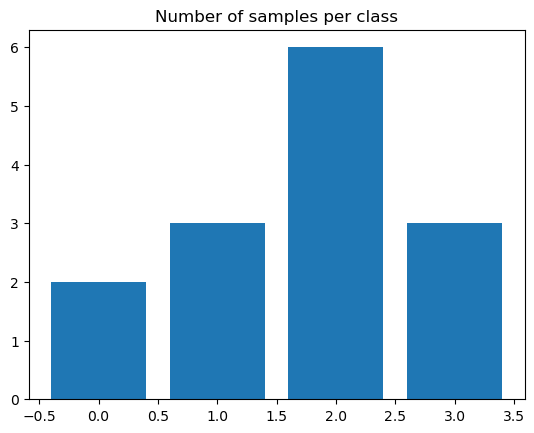

In [12]:
num_classes = len(set(scores))
unique, counts = np.unique(scores, return_counts=True)
print(num_classes)
print(type(num_classes))
plt.bar(range(num_classes), counts)
plt.title("Number of samples per class")
plt.show()

In [13]:
print(len(series_list))
print(len(scores))
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    series_list, scores, test_size=0.15, random_state=42, shuffle=True
)

print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)

x_train = np.asarray(x_train).astype(np.float32).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

14
14
Length of x_train : 11
Length of x_test : 3
Length of y_train : 11
Length of y_test : 3


In [14]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
vals_dict = {}
for i in scores:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)

{1: 0.7857142857142857, 0: 0.8571428571428572, 2: 0.5714285714285714, 3: 0.7857142857142857}


In [16]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [17]:
def create_model():
    input_layer = keras.Input(shape=(window_size, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [18]:
conv_model = create_model()

print(conv_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5798, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2899, 32)          128       
                                                                 
 batch_normalization (Batch  (None, 2899, 32)          128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 1450, 64)          6208      
                                                                 
 batch_normalization_1 (Bat  (None, 1450, 64)          256       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 725, 128)          41088 

In [19]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_top_k_categorical_accuracy",
        factor=0.2,
        patience=2,
        min_lr=0.000001,
    ),
]

optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()

In [ ]:
conv_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

conv_model_history = conv_model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)

Epoch 1/30
1/1 [==============================] - 24s 24s/step - loss: 45.0935 - top_k_categorical_accuracy: 0.7273 - auc: 0.3981 - precision: 0.1000 - recall: 0.0909 - val_loss: 43.5685 - val_top_k_categorical_accuracy: 0.6667 - val_auc: 0.4074 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/30
1/1 [==============================] - 4s 4s/step - loss: 62.6396 - top_k_categorical_accuracy: 0.9091 - auc: 0.6970 - precision: 0.5455 - recall: 0.5455 - val_loss: 42.7870 - val_top_k_categorical_accuracy: 0.6667 - val_auc: 0.5556 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/30
1/1 [==============================] - 4s 4s/step - loss: 57.1187 - top_k_categorical_accuracy: 0.9091 - auc: 0.5565 - precision: 0.3636 - recall: 0.3636 - val_loss: 42.3722 - val_top_k_categorical_accuracy: 0.6667 - val_auc: 0.4815 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/30
1/1 [==============================] - 31s 31s/step - los

In [ ]:
plot_history_metrics(conv_model_history)

In [ ]:
loss, accuracy, auc, precision, recall = conv_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")

In [ ]:
def view_evaluated_diameters_plots(model):
    start_index = 0
    end_index = number_of_points
    data = diams_df.loc[start_index:end_index, "diameters"]
    data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
    data_array = [np.asarray(data_array).astype(np.float32).reshape(-1, window_size, 1)]
    original_labels = diams_df.loc[start_index:end_index, "score"]
    predicted_labels = np.argmax(model.predict(data_array, verbose=0), axis=1)
    original_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in original_labels
    ]
    predicted_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in predicted_labels
    ]
    total_plots = number_of_points
    cols = total_plots // 3
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1
    pos = range(1, total_plots + 1)
    fig = plt.figure(figsize=(20, 10))
    for i, (plot_data, og_label, pred_label) in enumerate(
        zip(data, original_labels, predicted_labels)
    ):
        plt.subplot(rows, cols, pos[i])
        plt.plot(plot_data)
        plt.title(f"Actual Label : {og_label}\nPredicted Label : {pred_label}")
        fig.subplots_adjust(hspace=0.5)
    plt.show()


view_evaluated_diameters_plots(conv_model)